# Introduction

In the third installment of our series on fraud detection in banking using machine learning, we delve into the heart of the process: building a robust ML model. If you're just joining us, make sure to check out [**Part 1**](https://github.com/ameiln/Programming/blob/main/combine-datasets-in-pandas.ipynb) and [**Part 2**](https://github.com/ameiln/EDA-n-Modeling/blob/main/a-deep-dive-into-fraud-detection-through-eda.ipynb) for a detailed exploration of our exploratory data analysis (EDA) and an in-depth look at the dataset (you can download the dataset [**here**](https://www.kaggle.com/datasets/mohammadbolandraftar/my-dataset)).

Recap from Part 1 and 2:
In Part 1, we comprehensively examined our dataset, understanding its nuances and potential challenges. Part 2 then took us through the exploratory data analysis (EDA), where we uncovered valuable insights that laid the foundation for our model building journey.

In this installment, we delve into the heart of our fraud detection journey: creating machine learning models that can effectively distinguish between genuine transactions and fraudulent activities. To ensure the reliability of our models, we confront the challenge of overfitting. We test a variety of methods, including cross-validation and regularization techniques. Additionally, we embrace the power of collaboration by constructing an ensemble of models.

In [67]:
import numpy as np 
import pandas as pd 
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate, cross_val_score, cross_val_predict

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix


from sklearn.preprocessing import StandardScaler

# Training ML models

In this step we'll do the following:
- we'll evaluate ML models on the dataset loaded from EDA (no scaling, outlier detection, or other transformation)
- if the results are not satisfactory, we'll do oversampling
- if the model overfits, we'll do feature selection to address overfitting
- finally, we'll try more complex models to compare the results

in this step, in the training set, we'll do cross validation: it helps us to take advantage of the entire dataset and at the same time to overcome overfitting (although it reduces the speed)

Also, we'll use randomized search to find the best hyperparameters in our models.

We'll evaluate the model by a variety of metrics but our main metric is **F1 Score**

### **Download the datasets**

you can download the dataset from [**this Kaggle page**](https://www.kaggle.com/datasets/mohammadbolandraftar/my-dataset)

In [68]:
train_df= pd.read_csv("/kaggle/input/my-dataset/train_after_EDA.csv")
test_df= pd.read_csv("/kaggle/input/my-dataset/test_after_EDA.csv")

print(train_df.shape)
print(test_df.shape)

(11903, 118)
(2976, 118)


In [69]:
train_df_1 = train_df.copy()
test_df_1 = test_df.copy()

In [70]:
X = train_df_1.drop("FRAUD_FLAG", axis=1)
y = train_df_1["FRAUD_FLAG"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print("X_train.shape:", X_train.shape, "   X_test.shape:",X_test.shape, "   y_train.shape:", y_train.shape, "   y_test.shape:", y_test.shape)

X_train.shape: (8332, 117)    X_test.shape: (3571, 117)    y_train.shape: (8332,)    y_test.shape: (3571,)


# 1. No oversampling

The first try is with the model from the previous section which is an imbalanced dataset

## Decision Trees

Best Parameters:
{'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 12}

cross validation score:
[0.93161368 0.94181164 0.93937575 0.93637455 0.93757503]

#####################         Train results         #####################
f1 score: 0.541958041958042

conf_matrix:
[[7498  191]
 [ 333  310]]

precision score: 0.6187624750499002

recall score: 0.4821150855365474

auc_roc: 0.776252840043147


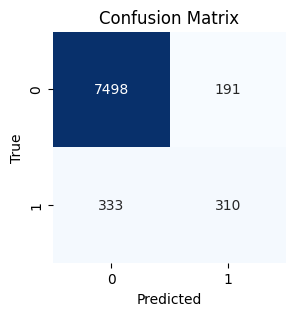

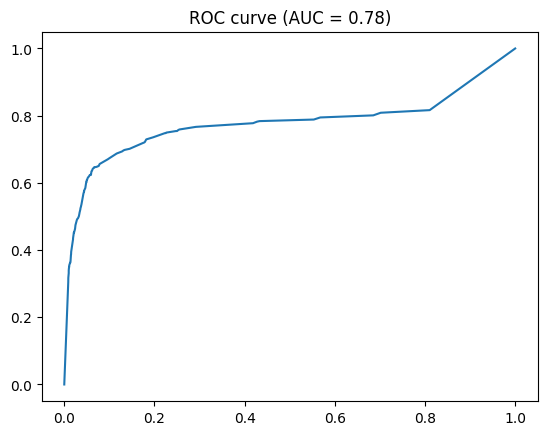


#####################         Test results         #####################
f1 score: 0.5301204819277109

conf_matrix:
[[3205   91]
 [ 143  132]]

precision score: 0.5919282511210763

recall score: 0.48

auc_roc: 0.8046977052074139


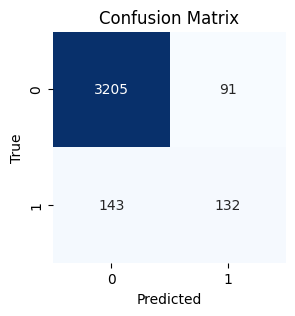

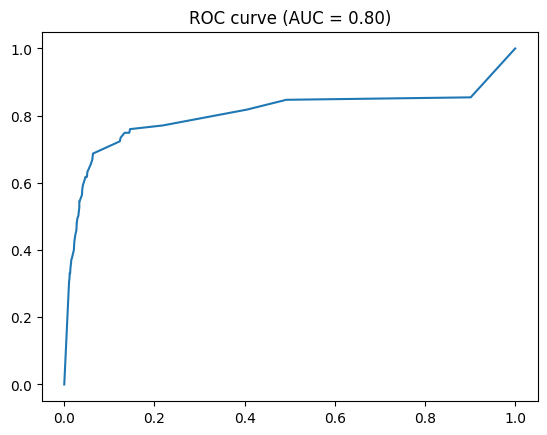

In [71]:
DT_1 = DecisionTreeClassifier()

param_grid = {
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": randint(low=2, high=30),
    "min_samples_leaf": randint(low=1, high=5),
    "max_features": [None, "sqrt", "log2"],
}

random_search = RandomizedSearchCV(
    estimator = DT_1, 
    param_distributions = param_grid, 
    n_iter = 20,
    scoring = make_scorer(f1_score),
    cv = 5,
    random_state = 42
)

random_search.fit(X_train, y_train)

best_model_DT_1 = random_search.best_estimator_
best_params_DT_1 = random_search.best_params_

cross_val_score_DT_1 = cross_val_score(best_model_DT_1, X_train, y_train, cv=5)

print("Best Parameters:")
print(best_params_DT_1)
print()
print("cross validation score:")
print(cross_val_score_DT_1)
print()

y_train_pred_DT_1 = cross_val_predict(best_model_DT_1, X_train, y_train, cv=5)
y_train_pred_proba_DT_1 = cross_val_predict(best_model_DT_1, X_train, y_train, cv=5, method="predict_proba")[:, 1]

importance_DT_1 = best_model_DT_1.feature_importances_

print("#####################         Train results         #####################")
f1 = f1_score(y_train, y_train_pred_DT_1)
conf_matrix = confusion_matrix(y_train, y_train_pred_DT_1)
precision = precision_score(y_train, y_train_pred_DT_1)
recall = recall_score(y_train, y_train_pred_DT_1)
auc_roc = roc_auc_score(y_train, y_train_pred_proba_DT_1)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_proba_DT_1)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()



y_test_pred_DT_1 = best_model_DT_1.predict(X_test)
y_test_pred_proba_DT_1 = best_model_DT_1.predict_proba(X_test)[:,1]

print()
print("#####################         Test results         #####################")
f1 = f1_score(y_test, y_test_pred_DT_1)
auc_roc = roc_auc_score(y_test, y_test_pred_proba_DT_1)
conf_matrix = confusion_matrix(y_test, y_test_pred_DT_1)
precision = precision_score(y_test, y_test_pred_DT_1)
recall = recall_score(y_test, y_test_pred_DT_1)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_DT_1)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()

The results in both train and test sets are fairly low. so, **we'll perform oversampling** to see if we can have a higher performance or not

# 2. no feature selection , no scaling, no outlier detection, **WITH oversampling**

## 2.1. Oversampling

In [72]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
y_train_resampled.value_counts()

FRAUD_FLAG
0.0    7689
1.0    7689
Name: count, dtype: int64

## Decision Trees (oversampled)

Best Parameters:
{'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 8}

cross validation score:
[0.87288687 0.95513654 0.94895969 0.95284553 0.94243902]

#####################         Train results         #####################
f1 score: 0.9334889148191367

conf_matrix:
[[7152  537]
 [ 489 7200]]

precision score: 0.9305932531989143

recall score: 0.9364026531408506

auc_roc: 0.9384625654345453


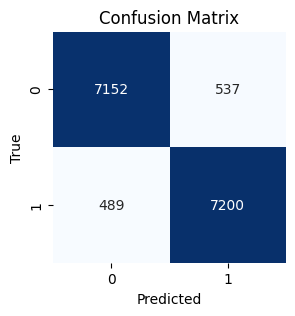

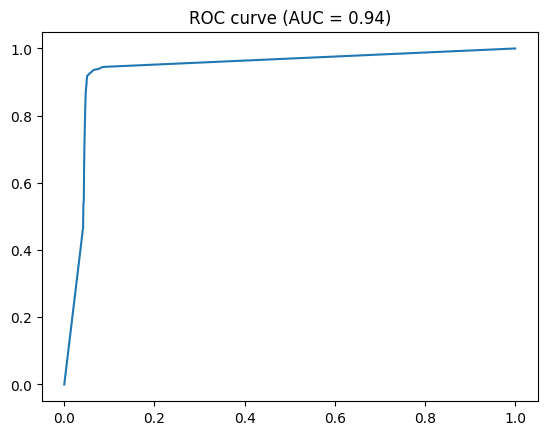


#####################         Test results         #####################
f1 score: 0.45053272450532733

conf_matrix:
[[3062  234]
 [ 127  148]]

precision score: 0.387434554973822

recall score: 0.5381818181818182

auc_roc: 0.7750827449249779


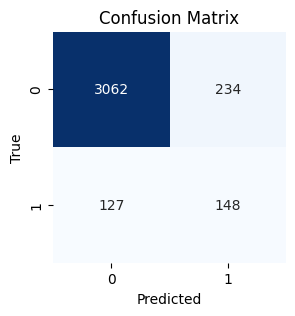

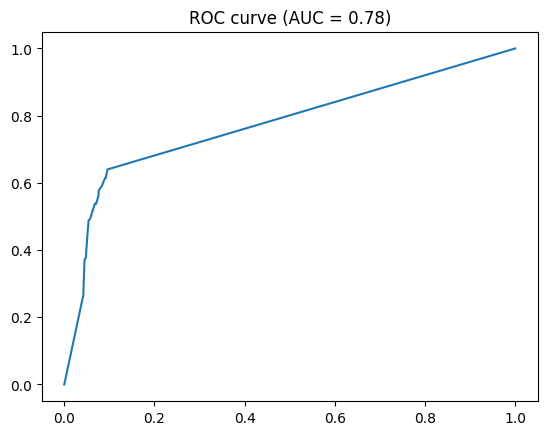

In [73]:
DT_2 = DecisionTreeClassifier()

param_grid = {
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": randint(low=2, high=30),
    "min_samples_leaf": randint(low=1, high=5),
    "max_features": [None, "sqrt", "log2"],
}

random_search = RandomizedSearchCV(
    estimator = DT_2, 
    param_distributions = param_grid, 
    n_iter = 20,
    scoring = make_scorer(f1_score),
    cv = 5,
    random_state = 42
)

random_search.fit(X_train_resampled, y_train_resampled)

best_model_DT_2 = random_search.best_estimator_
best_params_DT_2 = random_search.best_params_

cross_val_score_DT_2 = cross_val_score(best_model_DT_2, X_train_resampled, y_train_resampled, cv=5)

print("Best Parameters:")
print(best_params_DT_2)
print()
print("cross validation score:")
print(cross_val_score_DT_2)
print()

y_train_pred_DT_2 = cross_val_predict(best_model_DT_2, X_train_resampled, y_train_resampled, cv=5)
y_train_pred_proba_DT_2 = cross_val_predict(best_model_DT_2, X_train_resampled, y_train_resampled, cv=5, method="predict_proba")[:, 1]

importance_DT_2 = best_model_DT_2.feature_importances_


print("#####################         Train results         #####################")
f1 = f1_score(y_train_resampled, y_train_pred_DT_2)
conf_matrix = confusion_matrix(y_train_resampled, y_train_pred_DT_2)
precision = precision_score(y_train_resampled, y_train_pred_DT_2)
recall = recall_score(y_train_resampled, y_train_pred_DT_2)
auc_roc = roc_auc_score(y_train_resampled, y_train_pred_proba_DT_2)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_train_resampled, y_train_pred_proba_DT_2)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()


y_test_pred_DT_2 = best_model_DT_2.predict(X_test)
y_test_pred_proba_DT_2 = best_model_DT_2.predict_proba(X_test)[:,1]

print()
print("#####################         Test results         #####################")
f1 = f1_score(y_test, y_test_pred_DT_2)
auc_roc = roc_auc_score(y_test, y_test_pred_proba_DT_2)
conf_matrix = confusion_matrix(y_test, y_test_pred_DT_2)
precision = precision_score(y_test, y_test_pred_DT_2)
recall = recall_score(y_test, y_test_pred_DT_2)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_DT_2)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()

after applying oversampling, we noticed that the performance metrics in training dataset improved dramatically. however, there is a noticeable gap between train and test results. so, we have **overfitting**.


# 3. dealing with overfitting

our data is overfitting
So, we need to work on features and feature selection to have a better combination of features. We'll do the following:
- First, removing the features with one unique values
- Applying Lasso (L1 regularization) to perform feature selection
- Applying Random Forest and using the fetures with over 3% importance, as a feature selection technique

## 3.1. First layer of feature selection

In [74]:
# filtering the columns with one unique value only
one_or_zer_unique_val_features = [col for col in train_df.columns if train_df[col].nunique() <= 1]
print("columns with one or zero unique values:")
print(one_or_zer_unique_val_features)

columns with one or zero unique values:
['FLAG_RECREA', 'FLAG_FASTFOOD', 'FLAG_GAS', 'FLAG_HIGH_RECREA', 'FLAG_INTERNET', 'FLAG_MANUAL_ENTRY', 'FLAG_SWIPE']


In [75]:
auto_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("auto")])
fastfood_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("fast")])
gas_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("gas")])
high_recrea_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("high_recrea")])
internet_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("internet")])
fashion_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("fashion")])
manual_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("manual")])
swipe_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("swipe")])
temp = list(train_df.columns[train_df.columns.str.lower().str.contains("recrea")])
recrea_columns = [col for col in temp if col not in high_recrea_columns]

print(auto_columns)
print()
print(fastfood_columns)
print()
print(gas_columns)
print()
print(high_recrea_columns)
print()
print(internet_columns)
print()
print(fashion_columns)
print()
print(manual_columns)
print()
print(swipe_columns)
print()
print(recrea_columns)
print()
print(len(auto_columns) + len(fastfood_columns) + len(gas_columns) + len(high_recrea_columns) + len(internet_columns) + len(fashion_columns)\
      + len(manual_columns) + len(swipe_columns) + len(recrea_columns))

['FLAG_AUTO', 'MEAN_AUTO_PAST_7DAY', 'COUNT_AUTO_PAST_7DAY', 'MEAN_AUTO_PAST_30DAY', 'STD_AUTO_PAST_30DAY', 'SUM_AUTO_PAST_30DAY', 'auto_mean_ratio', 'auto_sum_ratio']

['FLAG_FASTFOOD', 'MEAN_FASTFOOD_PAST_7DAY', 'STD_FASTFOOD_PAST_7DAY', 'MAX_FASTFOOD_PAST_30DAY', 'SUM_FASTFOOD_PAST_30DAY', 'COUNT_FASTFOOD_PAST_30DAY']

['FLAG_GAS', 'gas_sum7_count7_ratio', 'gas_sum30_count30_ratio']

['FLAG_HIGH_RECREA', 'MAX_HIGH_RECREA_PAST_7DAY', 'STD_HIGH_RECREA_PAST_30DAY', 'SUM_HIGH_RECREA_PAST_30DAY']

['FLAG_INTERNET', 'STD_INTERNET_PAST_7DAY', 'COUNT_INTERNET_PAST_7DAY', 'STD_INTERNET_PAST_30DAY', 'SUM_INTERNET_PAST_30DAY']

['FLAG_FASHION', 'MEAN_FASHION_PAST_7DAY']

['FLAG_MANUAL_ENTRY', 'MEAN_MANUAL_ENTRY_PAST_7DAY', 'COUNT_MANUAL_ENTRY_PAST_7DAY', 'MEAN_MANUAL_ENTRY_PAST_30DAY', 'SUM_MANUAL_ENTRY_PAST_30DAY']

['FLAG_SWIPE', 'MEAN_SWIPE_PAST_7DAY', 'STD_SWIPE_PAST_7DAY', 'SUM_SWIPE_PAST_7DAY', 'swipe_sum30_count30_ratio']

['FLAG_RECREA', 'MEAN_RECREA_PAST_7DAY', 'MAX_RECREA_PAST_7DAY',

Now , we remove the columns and create the new features:

In [76]:
features_to_drop = auto_columns + fastfood_columns + gas_columns + high_recrea_columns + internet_columns + fashion_columns + manual_columns + swipe_columns + recrea_columns
new_features = [col for col in X_train_resampled.columns if col not in features_to_drop]

X_train_one_unique_feature = X_train_resampled[new_features]
X_test_one_unique_feature = X_test[new_features]

print(X_train_one_unique_feature.shape, X_test_one_unique_feature.shape)


(15378, 70) (3571, 70)


In [77]:
X_train_one_unique_feature.head(2)

,AVAIL_CRDT,AMOUNT,FLAG_LX,FLAG_APPAREL,FLAG_DEAL,FLAG_ENTERTAINMENT,FLAG_GIFT_CARD,FLAG_HIGH_AMT,FLAG_INTERNATIONAL,FLAG_LOW_AMT,FLAG_ELCTRNCS,FLAG_HEALTH,MEAN_APPAREL_PAST_7DAY,MEAN_GIFT_CARD_PAST_7DAY,MEAN_HIGH_AMT_PAST_7DAY,MEAN_INTERNATIONAL_PAST_7DAY,MEAN_LOW_AMT_PAST_7DAY,MEAN_ELCTRNCS_PAST_7DAY,MEAN_WEEKEND_PAST_7DAY,STD_LX_PAST_7DAY,STD_HIGH_AMT_PAST_7DAY,STD_LOW_AMT_PAST_7DAY,STD_HEALTH_PAST_7DAY,SUM_LX_PAST_7DAY,SUM_LOW_AMT_PAST_7DAY,SUM_PARTIAL_PAST_7DAY,SUM_WEEKEND_PAST_7DAY,COUNT_ENTERTAINMENT_PAST_7DAY,COUNT_WEEKEND_PAST_7DAY,MEAN_DEAL_PAST_30DAY,MEAN_ENTERTAINMENT_PAST_30DAY,MEAN_GIFT_CARD_PAST_30DAY,MEAN_HIGH_AMT_PAST_30DAY,MEAN_LOW_AMT_PAST_30DAY,MEAN_ELCTRNCS_PAST_30DAY,MEAN_WEEKEND_PAST_30DAY,MAX_PARTIAL_PAST_30DAY,STD_APPAREL_PAST_30DAY,STD_ENTERTAINMENT_PAST_30DAY,STD_GIFT_CARD_PAST_30DAY,STD_LOW_AMT_PAST_30DAY,STD_PARTIAL_PAST_30DAY,SUM_DEAL_PAST_30DAY,SUM_GIFT_CARD_PAST_30DAY,SUM_LOW_AMT_PAST_30DAY,SUM_WEEKEND_PAST_30DAY,COUNT_GIFT_CARD_PAST_30DAY,COUNT_ELCTRNCS_PAST_30DAY,COUNT_WEEKEND_PAST_30DAY,deal_mean30_sum30_ratio,gift_card_mean7_mean30_ratio,high_amt_sum30_count30_ratio,health_mean7_count_7_ratio,health_mean30_count_30_ratio,day_of_week_categorized,hour_of_day_categorized_0,hour_of_day_categorized_1,hour_of_day_categorized_2,add-shipping-address,add-payment-method,payment-failed,update-shipping-address,update-payment-method,forgot-password,OS_FAMILY_categorized_0,OS_FAMILY_categorized_1,OS_FAMILY_categorized_2,OS_FAMILY_categorized_3,TIME_SPENT_log_transformed,city_categorical
0,11958.67,0.97,0,1,0,1,0,0,0,1,0,0,0.97,0.0,0.0,0.0,5.64,60.48,7.8,0.0,0.0,6.2,0.0,0.0,11.28,0.0,24.6,0,3,0.0,0.97,0.0,0.0,5.64,57.52,23.96,0.0,14.82,0.0,0.0,6.52,0.0,0.0,0.0,10.72,191.68,0,2,8,0.0,0.0,0.0,115.04,115.04,0,0,0,1,0,0,0,1,0,0,1,0,0,0,6.665684,1
1,0.00,28.70,0,1,0,0,0,0,0,0,0,0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0,0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0,0,0,0.0,0.0,0.0,0.00,0.00,0,0,1,0,0,0,0,0,0,0,1,0,0,0,7.177019,0


## 3.1.2. Applying the first layer of feature selection on Decision Trees 

Best Parameters:
{'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 8}

cross validation score:
[0.86638492 0.94668401 0.93953186 0.94211382 0.93658537]

#####################         Train results         #####################
f1 score: 0.9278029812054439

conf_matrix:
[[7106  583]
 [ 531 7158]]

precision score: 0.9246867329802351

recall score: 0.9309403043308623

auc_roc: 0.9399680443680651


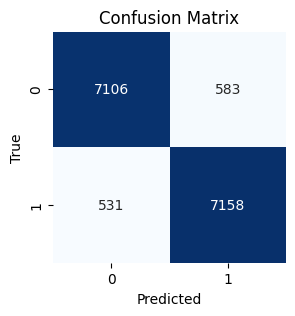

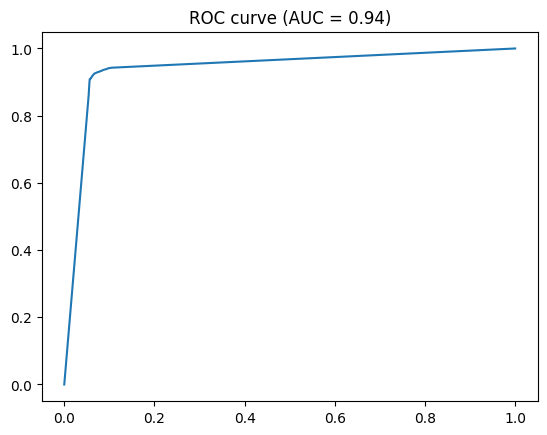


#####################         Test results         #####################
f1 score: 0.39933444259567386

conf_matrix:
[[3090  206]
 [ 155  120]]

precision score: 0.36809815950920244

recall score: 0.43636363636363634

auc_roc: 0.733145410414828


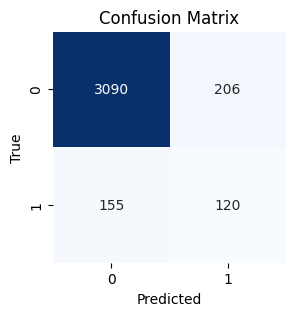

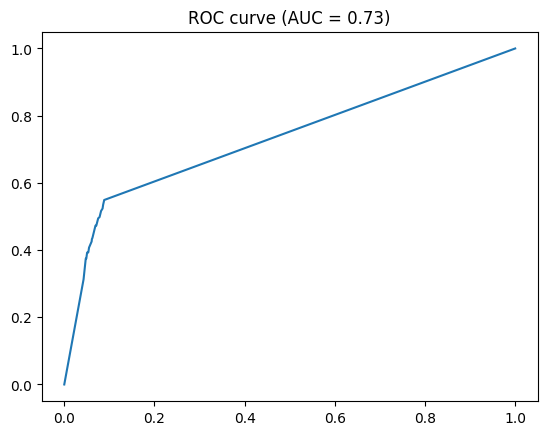

In [78]:
DT_3_1 = DecisionTreeClassifier()

param_grid = {
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": randint(low=2, high=30),
    "min_samples_leaf": randint(low=1, high=5),
    "max_features": [None, "sqrt", "log2"],
}

random_search = RandomizedSearchCV(
    estimator = DT_3_1, 
    param_distributions = param_grid, 
    n_iter = 20,
    scoring = make_scorer(f1_score),
    cv = 5,
    random_state = 42
)

random_search.fit(X_train_one_unique_feature, y_train_resampled)

best_model_DT_3_1 = random_search.best_estimator_
best_params_DT_3_1 = random_search.best_params_

cross_val_score_DT_3_1 = cross_val_score(best_model_DT_3_1, X_train_one_unique_feature, y_train_resampled, cv=5)

print("Best Parameters:")
print(best_params_DT_3_1)
print()
print("cross validation score:")
print(cross_val_score_DT_3_1)
print()

y_train_pred_DT_3_1 = cross_val_predict(best_model_DT_3_1, X_train_one_unique_feature, y_train_resampled, cv=5)
y_train_pred_proba_DT_3_1 = cross_val_predict(best_model_DT_3_1, X_train_one_unique_feature, y_train_resampled, 
                                            cv=5, method="predict_proba")[:, 1]

importance_DT_3_1 = best_model_DT_3_1.feature_importances_


print("#####################         Train results         #####################")
f1 = f1_score(y_train_resampled, y_train_pred_DT_3_1)
conf_matrix = confusion_matrix(y_train_resampled, y_train_pred_DT_3_1)
precision = precision_score(y_train_resampled, y_train_pred_DT_3_1)
recall = recall_score(y_train_resampled, y_train_pred_DT_3_1)
auc_roc = roc_auc_score(y_train_resampled, y_train_pred_proba_DT_3_1)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_train_resampled, y_train_pred_proba_DT_3_1)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()


y_test_pred_DT_3_1= best_model_DT_3_1.predict(X_test_one_unique_feature)
y_test_pred_proba_DT_3_1 = best_model_DT_3_1.predict_proba(X_test_one_unique_feature)[:,1]


print()
print("#####################         Test results         #####################")
f1 = f1_score(y_test, y_test_pred_DT_3_1)
auc_roc = roc_auc_score(y_test, y_test_pred_proba_DT_3_1)
conf_matrix = confusion_matrix(y_test, y_test_pred_DT_3_1)
precision = precision_score(y_test, y_test_pred_DT_3_1)
recall = recall_score(y_test, y_test_pred_DT_3_1)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_DT_3_1)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()

The test results are still low. In the next step, we'll apply Lasso feature selection

## 3.2. Applying the second layer of feature selection (Lasso)

In this step we apply the Lasso technique for feature selection

In [79]:
lasso_cv_1 = LassoCV(alphas=[0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10], cv=5)
lasso_cv_1.fit(X_train_one_unique_feature, y_train_resampled)
best_alpha = lasso_cv_1.alpha_
print("best alpha:", best_alpha)

lasso_1 = Lasso(alpha = best_alpha)
lasso_1.fit(X_train_one_unique_feature, y_train_resampled)

feature_selector_1 = SelectFromModel(lasso_1, threshold="median")
feature_selector_1.fit(X_train_one_unique_feature, y_train_resampled)

selected_features_1 = feature_selector_1.get_support(indices=True)
print("length of selected features", len(selected_features_1))
X_train_selected_lasso = X_train_one_unique_feature.iloc[:, selected_features_1]
X_test_selected_lasso = X_test_one_unique_feature.iloc[:, selected_features_1]

print()
print("name of the selected features:")
print(X_train_one_unique_feature.columns[list(selected_features_1)])

print("shape of X_Train:", X_train_selected_lasso.shape)
print()
print("shape of X_Test:", X_test_selected_lasso.shape)
print()
X_train_selected_lasso.head(2)

best alpha: 0.0005
length of selected features 35

name of the selected features:
Index(['FLAG_LX', 'FLAG_APPAREL', 'FLAG_ENTERTAINMENT', 'FLAG_GIFT_CARD',
       'FLAG_HIGH_AMT', 'FLAG_INTERNATIONAL', 'FLAG_LOW_AMT', 'FLAG_ELCTRNCS',
       'MEAN_LOW_AMT_PAST_7DAY', 'STD_LOW_AMT_PAST_7DAY',
       'COUNT_ENTERTAINMENT_PAST_7DAY', 'COUNT_WEEKEND_PAST_7DAY',
       'MEAN_LOW_AMT_PAST_30DAY', 'STD_LOW_AMT_PAST_30DAY',
       'STD_PARTIAL_PAST_30DAY', 'COUNT_GIFT_CARD_PAST_30DAY',
       'COUNT_ELCTRNCS_PAST_30DAY', 'COUNT_WEEKEND_PAST_30DAY',
       'deal_mean30_sum30_ratio', 'gift_card_mean7_mean30_ratio',
       'day_of_week_categorized', 'hour_of_day_categorized_0',
       'hour_of_day_categorized_1', 'hour_of_day_categorized_2',
       'add-shipping-address', 'add-payment-method', 'payment-failed',
       'update-shipping-address', 'update-payment-method', 'forgot-password',
       'OS_FAMILY_categorized_0', 'OS_FAMILY_categorized_1',
       'OS_FAMILY_categorized_2', 'OS_FAMILY_cate

,FLAG_LX,FLAG_APPAREL,FLAG_ENTERTAINMENT,FLAG_GIFT_CARD,FLAG_HIGH_AMT,FLAG_INTERNATIONAL,FLAG_LOW_AMT,FLAG_ELCTRNCS,MEAN_LOW_AMT_PAST_7DAY,STD_LOW_AMT_PAST_7DAY,COUNT_ENTERTAINMENT_PAST_7DAY,COUNT_WEEKEND_PAST_7DAY,MEAN_LOW_AMT_PAST_30DAY,STD_LOW_AMT_PAST_30DAY,STD_PARTIAL_PAST_30DAY,COUNT_GIFT_CARD_PAST_30DAY,COUNT_ELCTRNCS_PAST_30DAY,COUNT_WEEKEND_PAST_30DAY,deal_mean30_sum30_ratio,gift_card_mean7_mean30_ratio,day_of_week_categorized,hour_of_day_categorized_0,hour_of_day_categorized_1,hour_of_day_categorized_2,add-shipping-address,add-payment-method,payment-failed,update-shipping-address,update-payment-method,forgot-password,OS_FAMILY_categorized_0,OS_FAMILY_categorized_1,OS_FAMILY_categorized_2,OS_FAMILY_categorized_3,TIME_SPENT_log_transformed
0,0,1,1,0,0,0,1,0,5.64,6.2,0,3,5.64,6.52,0.0,0,2,8,0.0,0.0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,6.665684
1,0,1,0,0,0,0,0,0,0.00,0.0,0,0,0.00,0.00,0.0,0,0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,7.177019


By applying Lasso, the number of features is reduced to 35

## 3.3 Decision Trees after applying Lasso feature selection

Best Parameters:
{'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 8}

cross validation score:
[0.81697009 0.94115735 0.9336801  0.93495935 0.94601626]

#####################         Train results         #####################
f1 score: 0.9123498128816229

conf_matrix:
[[7095  594]
 [ 741 6948]]

precision score: 0.9212410501193318

recall score: 0.9036285602809208

auc_roc: 0.9288687886604089


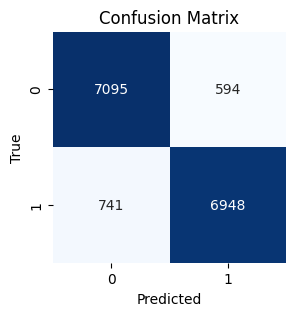

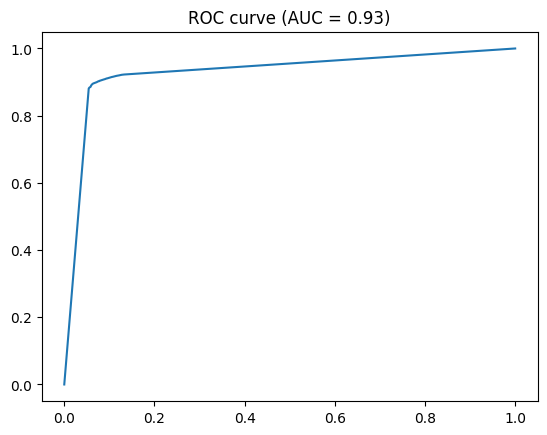


#####################         Test results         #####################
f1 score: 0.3321917808219178

conf_matrix:
[[3084  212]
 [ 178   97]]

precision score: 0.313915857605178

recall score: 0.3527272727272727

auc_roc: 0.7122765887025595


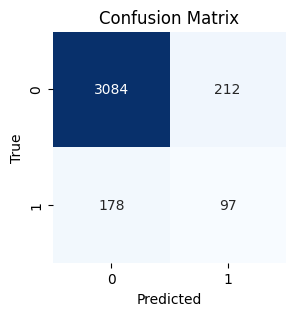

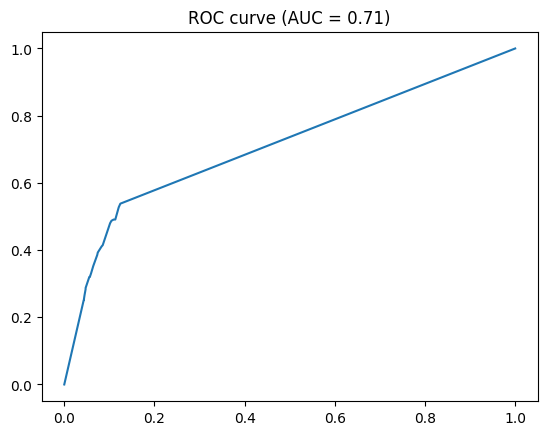

In [80]:
DT_3_2 = DecisionTreeClassifier()

param_grid = {
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": randint(low=2, high=30),
    "min_samples_leaf": randint(low=1, high=5),
    "max_features": [None, "sqrt", "log2"],
}

random_search = RandomizedSearchCV(
    estimator = DT_3_2, 
    param_distributions = param_grid, 
    n_iter = 20,
    scoring = make_scorer(f1_score),
    cv = 5,
    random_state = 42
)

random_search.fit(X_train_selected_lasso, y_train_resampled)

best_model_DT_3_2 = random_search.best_estimator_
best_params_DT_3_2 = random_search.best_params_

cross_val_score_DT_3_2 = cross_val_score(best_model_DT_3_2, X_train_selected_lasso, y_train_resampled, cv=5)

print("Best Parameters:")
print(best_params_DT_3_2)
print()
print("cross validation score:")
print(cross_val_score_DT_3_2)
print()

y_train_pred_DT_3_2 = cross_val_predict(best_model_DT_3_2, X_train_selected_lasso, y_train_resampled, cv=5)
y_train_pred_proba_DT_3_2 = cross_val_predict(best_model_DT_3_2, X_train_selected_lasso, y_train_resampled, 
                                            cv=5, method="predict_proba")[:, 1]

importance_DT_3_2 = best_model_DT_3_2.feature_importances_


print("#####################         Train results         #####################")
f1 = f1_score(y_train_resampled, y_train_pred_DT_3_2)
conf_matrix = confusion_matrix(y_train_resampled, y_train_pred_DT_3_2)
precision = precision_score(y_train_resampled, y_train_pred_DT_3_2)
recall = recall_score(y_train_resampled, y_train_pred_DT_3_2)
auc_roc = roc_auc_score(y_train_resampled, y_train_pred_proba_DT_3_2)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_train_resampled, y_train_pred_proba_DT_3_2)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()


y_test_pred_DT_3_2= best_model_DT_3_2.predict(X_test_selected_lasso)
y_test_pred_proba_DT_3_2 = best_model_DT_3_2.predict_proba(X_test_selected_lasso)[:,1]


print()
print("#####################         Test results         #####################")
f1 = f1_score(y_test, y_test_pred_DT_3_2)
auc_roc = roc_auc_score(y_test, y_test_pred_proba_DT_3_2)
conf_matrix = confusion_matrix(y_test, y_test_pred_DT_3_2)
precision = precision_score(y_test, y_test_pred_DT_3_2)
recall = recall_score(y_test, y_test_pred_DT_3_2)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_DT_3_2)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()

Applying Lasso technique wasn't able to improve the model performance

## 3.4. Applying Random Forest

In this step we'll implement the Random Forest model. if it still overfits, we'll use the **important features from the model** and will reduce the dimension of the model

Best Parameters:
{'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 500}

cross validation score:
[0.91579974 0.9739922  0.9743173  0.97528455 0.96845528]

#####################         Train results         #####################
f1 score: 0.9615384615384616

conf_matrix:
[[7386  303]
 [ 289 7400]]

precision score: 0.9606646761002207

recall score: 0.9624138379503187

auc_roc: 0.9936673133604038


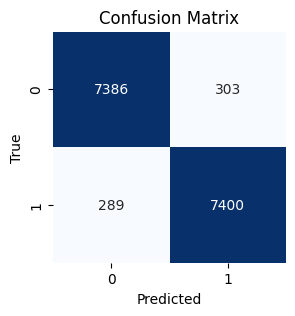

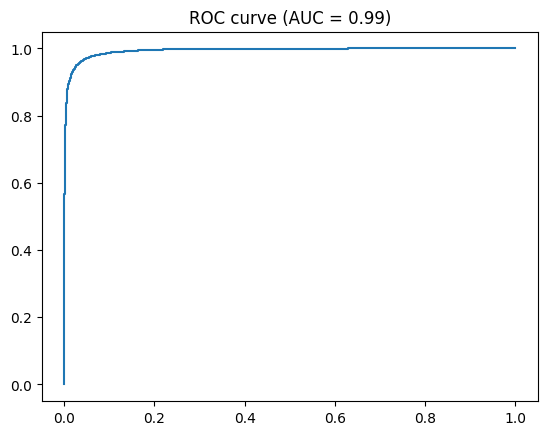


#####################         Test results         #####################
f1 score: 0.5974025974025974

conf_matrix:
[[3193  103]
 [ 114  161]]

precision score: 0.6098484848484849

recall score: 0.5854545454545454

auc_roc: 0.9266769638128862


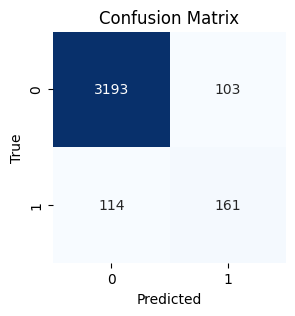

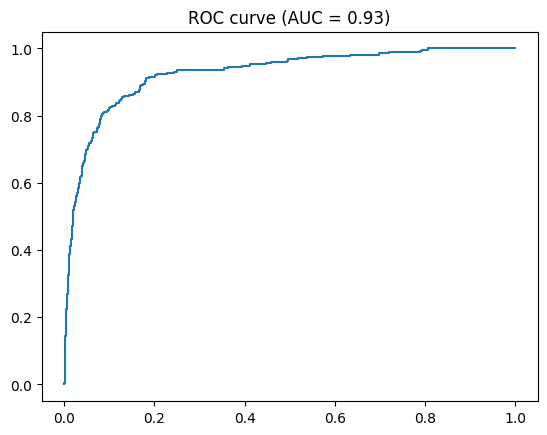

In [81]:
RF_3_3 = RandomForestClassifier()

param_grid = {
    "n_estimators": [400, 500],
    "max_depth": randint(low=10, high=20),
    "min_samples_split": randint(low=2, high=20),
    "min_samples_leaf": randint(low=4, high=10),
    "max_features": ["log2", "sqrt"],
}

random_search = RandomizedSearchCV(
    estimator = RF_3_3, 
    param_distributions = param_grid, 
    n_iter = 20,
    scoring = make_scorer(f1_score),
    cv = 5,
    random_state = 42
)

random_search.fit(X_train_resampled, y_train_resampled)

best_model_RF_3_3 = random_search.best_estimator_
best_params_RF_3_3 = random_search.best_params_

cross_val_score_RF_3_3 = cross_val_score(best_model_RF_3_3, X_train_resampled, y_train_resampled, cv=5)

print("Best Parameters:")
print(best_params_RF_3_3)
print()
print("cross validation score:")
print(cross_val_score_RF_3_3)
print()

y_train_pred_RF_3_3 = cross_val_predict(best_model_RF_3_3, X_train_resampled, y_train_resampled, cv=5)
y_train_pred_proba_RF_3_3 = cross_val_predict(best_model_RF_3_3, X_train_resampled, y_train_resampled, 
                                            cv=5, method="predict_proba")[:, 1]

importance_RF_3_3 = best_model_RF_3_3.feature_importances_


print("#####################         Train results         #####################")
f1 = f1_score(y_train_resampled, y_train_pred_RF_3_3)
conf_matrix = confusion_matrix(y_train_resampled, y_train_pred_RF_3_3)
precision = precision_score(y_train_resampled, y_train_pred_RF_3_3)
recall = recall_score(y_train_resampled, y_train_pred_RF_3_3)
auc_roc = roc_auc_score(y_train_resampled, y_train_pred_proba_RF_3_3)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_train_resampled, y_train_pred_proba_RF_3_3)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()


y_test_pred_RF_3_3 = best_model_RF_3_3.predict(X_test)
y_test_pred_proba_RF_3_3 = best_model_RF_3_3.predict_proba(X_test)[:,1]


print()
print("#####################         Test results         #####################")
f1 = f1_score(y_test, y_test_pred_RF_3_3)
auc_roc = roc_auc_score(y_test, y_test_pred_proba_RF_3_3)
conf_matrix = confusion_matrix(y_test, y_test_pred_RF_3_3)
precision = precision_score(y_test, y_test_pred_RF_3_3)
recall = recall_score(y_test, y_test_pred_RF_3_3)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted") 
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_RF_3_3)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()

### List of important features in Random Forest model

First, we'll do feature selection using the features with **>2%** importance

In [82]:
feature_importance_df = pd.DataFrame({"Feature": X_train_resampled.columns, 
                                      "Importance %": importance_RF_3_3 *100}).sort_values(by="Importance %", ascending=False)

RF_important_features = list(feature_importance_df[feature_importance_df["Importance %"] > 2]["Feature"])
print(RF_important_features)

X_train_selected_RF = X_train_resampled[RF_important_features]
X_test_selected_RF = X_test[RF_important_features]

print(X_train_selected_RF.shape)
print()
print(X_test_selected_RF.shape)
print()

['MEAN_INTERNATIONAL_PAST_7DAY', 'swipe_sum30_count30_ratio', 'OS_FAMILY_categorized_0']
(15378, 3)

(3571, 3)



In [83]:
X_train_selected_RF.head(2)

,MEAN_INTERNATIONAL_PAST_7DAY,swipe_sum30_count30_ratio,OS_FAMILY_categorized_0
0,0.0,2574.0,1
1,0.0,0.0,1


In [84]:
feature_importance_df.head(20)

,Feature,Importance %
27,MEAN_INTERNATIONAL_PAST_7DAY,10.922604
98,swipe_sum30_count30_ratio,8.521938
111,OS_FAMILY_categorized_0,3.589718
83,SUM_MANUAL_ENTRY_PAST_30DAY,2.922542
39,STD_INTERNET_PAST_7DAY,2.916511
16,FLAG_LOW_AMT,2.836319
61,MEAN_MANUAL_ENTRY_PAST_30DAY,2.616621
95,gas_sum30_count30_ratio,2.593095
1,AMOUNT,2.367159
51,COUNT_INTERNET_PAST_7DAY,2.210076


## 3.5 Applying the important features (> 2%) on Random Forest model again

Best Parameters:
{'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 100}

cross validation score:
[0.81729519 0.85175553 0.86183355 0.85821138 0.84715447]

#####################         Train results         #####################
f1 score: 0.8467926502321325

conf_matrix:
[[6560 1129]
 [1214 6475]]

precision score: 0.8515255128879538

recall score: 0.8421121082065288

auc_roc: 0.9222349132041201


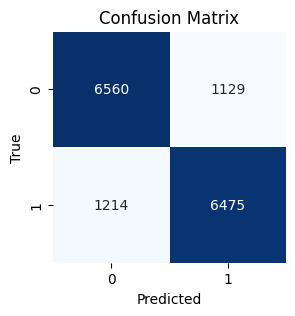

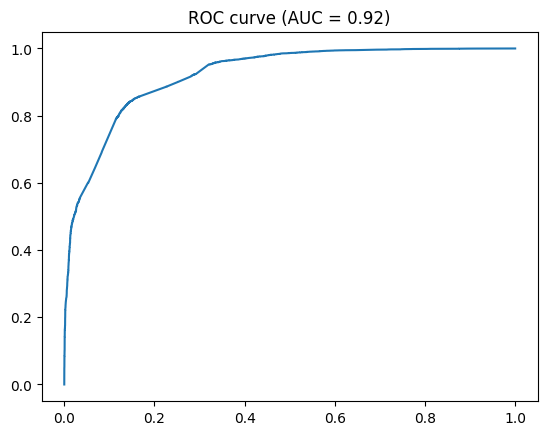


#####################         Test results         #####################
f1 score: 0.3465783664459161

conf_matrix:
[[2822  474]
 [ 118  157]]

precision score: 0.24881141045958796

recall score: 0.5709090909090909

auc_roc: 0.8469274051191527


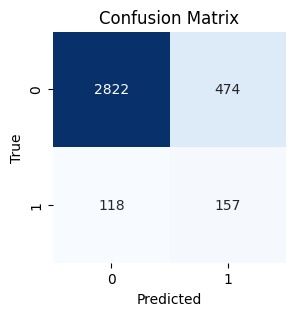

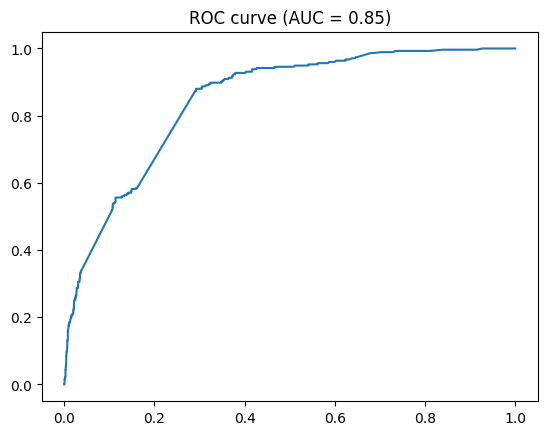

In [85]:
RF_3_3_1 = RandomForestClassifier()

param_grid = {
    "n_estimators": [100],
    "max_depth": randint(low=2, high=10),
    "min_samples_split": randint(low=2, high=10),
    "min_samples_leaf": randint(low=2, high=5),
    "max_features": ["log2", "sqrt"],
}

random_search = RandomizedSearchCV(
    estimator = RF_3_3_1, 
    param_distributions = param_grid, 
    n_iter = 20,
    scoring = make_scorer(f1_score),
    cv = 5,
    random_state = 42
)

random_search.fit(X_train_selected_RF, y_train_resampled)

best_model_RF_3_3_1 = random_search.best_estimator_
best_params_RF_3_3_1 = random_search.best_params_

cross_val_score_RF_3_3_1 = cross_val_score(best_model_RF_3_3_1, X_train_selected_RF, y_train_resampled, cv=5)

print("Best Parameters:")
print(best_params_RF_3_3_1)
print()
print("cross validation score:")
print(cross_val_score_RF_3_3_1)
print()

y_train_pred_RF_3_3_1 = cross_val_predict(best_model_RF_3_3_1, X_train_selected_RF, y_train_resampled, cv=5)
y_train_pred_proba_RF_3_3_1 = cross_val_predict(best_model_RF_3_3_1, X_train_selected_RF, y_train_resampled, 
                                            cv=5, method="predict_proba")[:, 1]

importance_RF_3_3_1 = best_model_RF_3_3_1.feature_importances_


print("#####################         Train results         #####################")
f1 = f1_score(y_train_resampled, y_train_pred_RF_3_3_1)
conf_matrix = confusion_matrix(y_train_resampled, y_train_pred_RF_3_3_1)
precision = precision_score(y_train_resampled, y_train_pred_RF_3_3_1)
recall = recall_score(y_train_resampled, y_train_pred_RF_3_3_1)
auc_roc = roc_auc_score(y_train_resampled, y_train_pred_proba_RF_3_3_1)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_train_resampled, y_train_pred_proba_RF_3_3_1)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()


y_test_pred_RF_3_3_1 = best_model_RF_3_3_1.predict(X_test_selected_RF)
y_test_pred_proba_RF_3_3_1 = best_model_RF_3_3_1.predict_proba(X_test_selected_RF)[:,1]


print()
print("#####################         Test results         #####################")
f1 = f1_score(y_test, y_test_pred_RF_3_3_1)
auc_roc = roc_auc_score(y_test, y_test_pred_proba_RF_3_3_1)
conf_matrix = confusion_matrix(y_test, y_test_pred_RF_3_3_1)
precision = precision_score(y_test, y_test_pred_RF_3_3_1)
recall = recall_score(y_test, y_test_pred_RF_3_3_1)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_RF_3_3_1)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()

None of the feature selection techniques worked. In the next step, we'll **apply PCA** to reduce the dimensions

## 3.6. Feature Selection using PCA

cumulative_variance_ratio: [0.90518136 0.99860065 0.9992258  0.99979323 0.99985476 0.99990917
 0.99993181 0.99994662 0.99995862 0.99996645 0.99997253 0.99997728
 0.99998021 0.99998262 0.99998476]


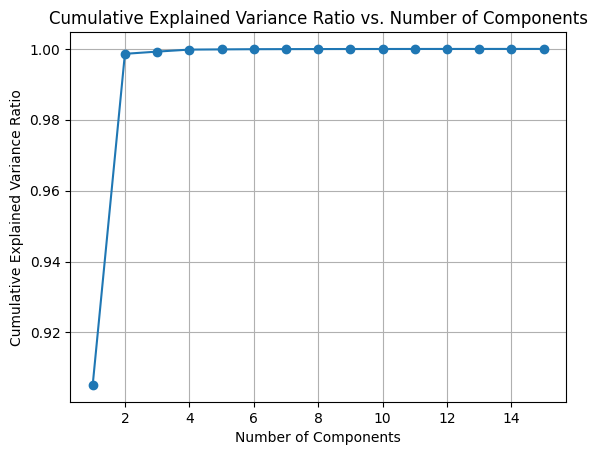

In [86]:
from sklearn.decomposition import PCA

pca = PCA(n_components=15)  

pca.fit(X_train_resampled)

#X_pca = pca.transform(X_train_resampled)

explained_variance_ratio = pca.explained_variance_ratio_

#singular_values = pca.singular_values_

cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
print("cumulative_variance_ratio:", cumulative_variance_ratio)

# Plot the cumulative explained variance ratio
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

In [87]:
X_reduced = pca.transform(X_train_resampled)
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y_train_resampled, 
                                                                                    test_size=0.3,
                                                                                    stratify=y_train_resampled,
                                                                                    random_state=42)
print(X_train_reduced.shape,X_test_reduced.shape,y_train_reduced.shape,y_test_reduced.shape)

(10764, 15) (4614, 15) (10764,) (4614,)


## 3.7. Decision Trees using the reduced PCA features

Best Parameters:
{'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 8}

cross validation score:
[0.86483976 0.86112401 0.87134231 0.87180678 0.86802974]

#####################         Train results         #####################
f1 score: 0.873141814865481

conf_matrix:
[[4586  796]
 [ 595 4787]]

precision score: 0.8574243238402293

recall score: 0.8894463024897807

auc_roc: 0.8880345229104378


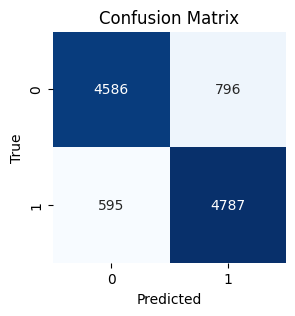

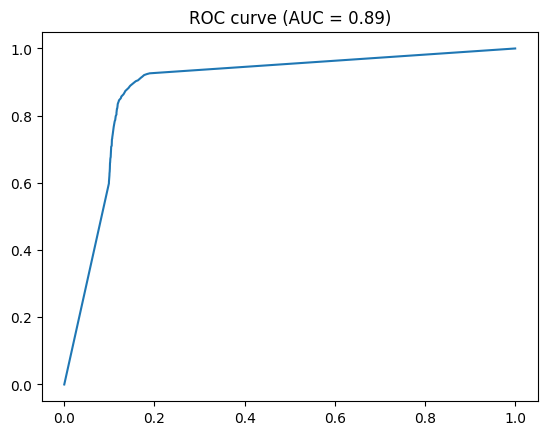


#####################         Test results         #####################
f1 score: 0.8831498729889924

conf_matrix:
[[1976  331]
 [ 221 2086]]

precision score: 0.8630533719486967

recall score: 0.9042045947117469

auc_roc: 0.8874556601917722


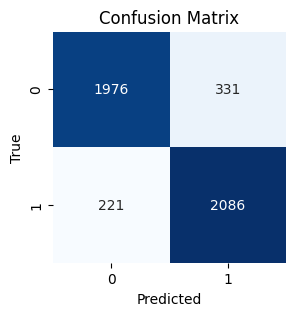

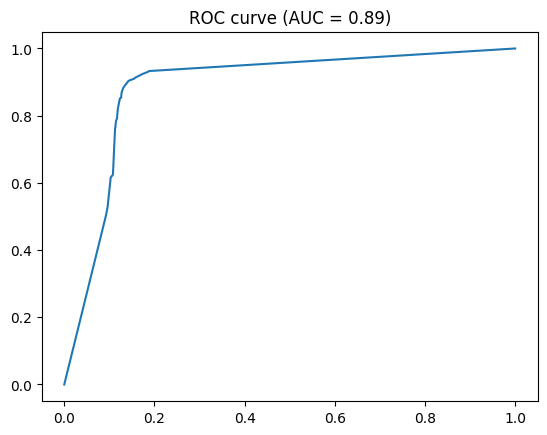

In [88]:
DT_3_4 = DecisionTreeClassifier()

param_grid = {
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": randint(low=2, high=30),
    "min_samples_leaf": randint(low=1, high=5),
    "max_features": [None, "sqrt", "log2"],
}

random_search = RandomizedSearchCV(
    estimator = DT_3_4, 
    param_distributions = param_grid, 
    n_iter = 20,
    scoring = make_scorer(f1_score),
    cv = 5,
    random_state = 42
)

random_search.fit(X_train_reduced, y_train_reduced)

best_model_DT_3_4 = random_search.best_estimator_
best_params_DT_3_4 = random_search.best_params_

cross_val_score_DT_3_4 = cross_val_score(best_model_DT_3_4, X_train_reduced, y_train_reduced, cv=5)

print("Best Parameters:")
print(best_params_DT_3_4)
print()
print("cross validation score:")
print(cross_val_score_DT_3_4)
print()

y_train_pred_DT_3_4 = cross_val_predict(best_model_DT_3_4, X_train_reduced, y_train_reduced, cv=5)
y_train_pred_proba_DT_3_4 = cross_val_predict(best_model_DT_3_4, X_train_reduced, y_train_reduced, cv=5, method="predict_proba")[:, 1]

importance_DT_3_2 = best_model_DT_3_2.feature_importances_


print("#####################         Train results         #####################")
f1 = f1_score(y_train_reduced, y_train_pred_DT_3_4)
conf_matrix = confusion_matrix(y_train_reduced, y_train_pred_DT_3_4)
precision = precision_score(y_train_reduced, y_train_pred_DT_3_4)
recall = recall_score(y_train_reduced, y_train_pred_DT_3_4)
auc_roc = roc_auc_score(y_train_reduced, y_train_pred_proba_DT_3_4)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_train_reduced, y_train_pred_proba_DT_3_4)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()


y_test_pred_DT_3_4= best_model_DT_3_4.predict(X_test_reduced)
y_test_pred_proba_DT_3_4 = best_model_DT_3_4.predict_proba(X_test_reduced)[:,1]


print()
print("#####################         Test results         #####################")
f1 = f1_score(y_test_reduced, y_test_pred_DT_3_4)
auc_roc = roc_auc_score(y_test_reduced, y_test_pred_proba_DT_3_4)
conf_matrix = confusion_matrix(y_test_reduced, y_test_pred_DT_3_4)
precision = precision_score(y_test_reduced, y_test_pred_DT_3_4)
recall = recall_score(y_test_reduced, y_test_pred_DT_3_4)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test_reduced, y_test_pred_proba_DT_3_4)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()

it seems that **PCA trick overcame the overfit issue**. We tried different number of components: [5, 10, 15, 20, 30, 40, 50] but the Decision Showed the best results when the number of components were 15. (Although 99% of explained variance were captured in the first 2 components)

# 4. feature scaling

In [89]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_reduced)
X_train_reduced_scaled = pd.DataFrame(X_train_scaled)

X_test_scaled = scaler.transform(X_test_reduced)
X_test_reduced_scaled = pd.DataFrame(X_test_scaled)

print(X_train_reduced_scaled.shape, X_test_reduced_scaled.shape)
X_train_reduced_scaled.head(2)

(10764, 15) (4614, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.509501,-0.376867,-1.006924,4.904472,0.143212,10.141687,-6.553586,-6.809450,2.581946,4.292512,-1.009717,2.347361,-5.412106,1.714355,-0.021929
1,-0.066008,-0.319726,-0.169339,0.217775,0.132216,0.190400,0.591086,-0.021632,-0.226363,0.123656,-1.159638,0.163698,0.400618,-0.440831,0.050968


# 5. outlier treatment (IQR method)

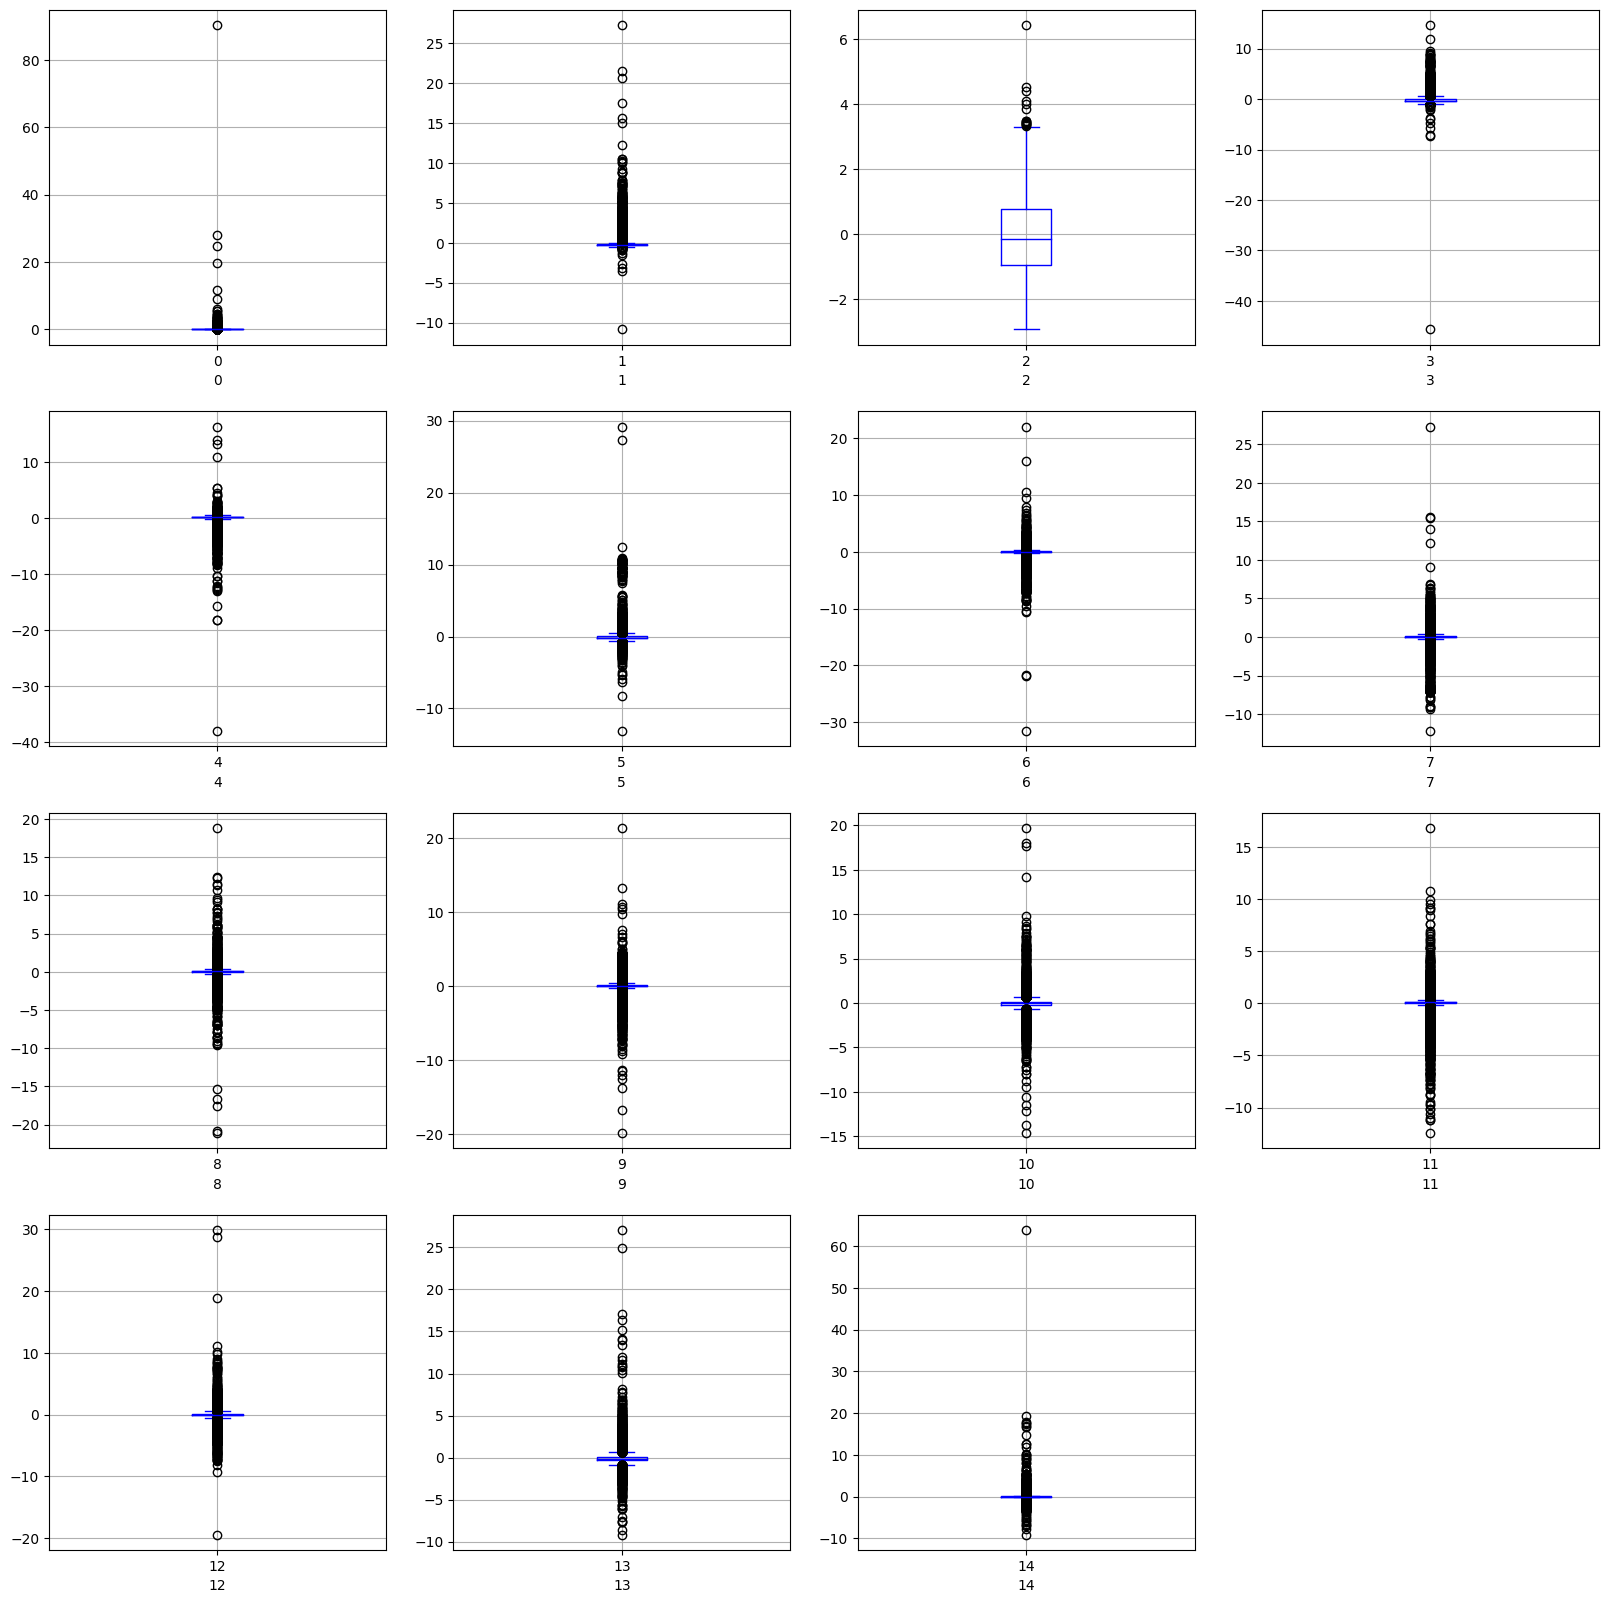

In [90]:
fig, axes = plt.subplots(4, 4, figsize=(20,20))

axes = axes.flatten()

for i, col in enumerate(X_train_reduced_scaled.columns):
    X_train_reduced_scaled.boxplot(column=col, ax=axes[i], color="blue")
    axes[i].set_xlabel(col)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.show()

In [91]:
Q1 = X_train_reduced_scaled.quantile(0.25)
Q3 = X_train_reduced_scaled.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

X_train_reduced_scaled_outliers_clipped = X_train_reduced_scaled.clip(lower_bound, upper_bound, axis=1)

X_test_reduced_scaled_outliers_clipped = X_test_reduced_scaled.clip(lower_bound, upper_bound, axis=1)

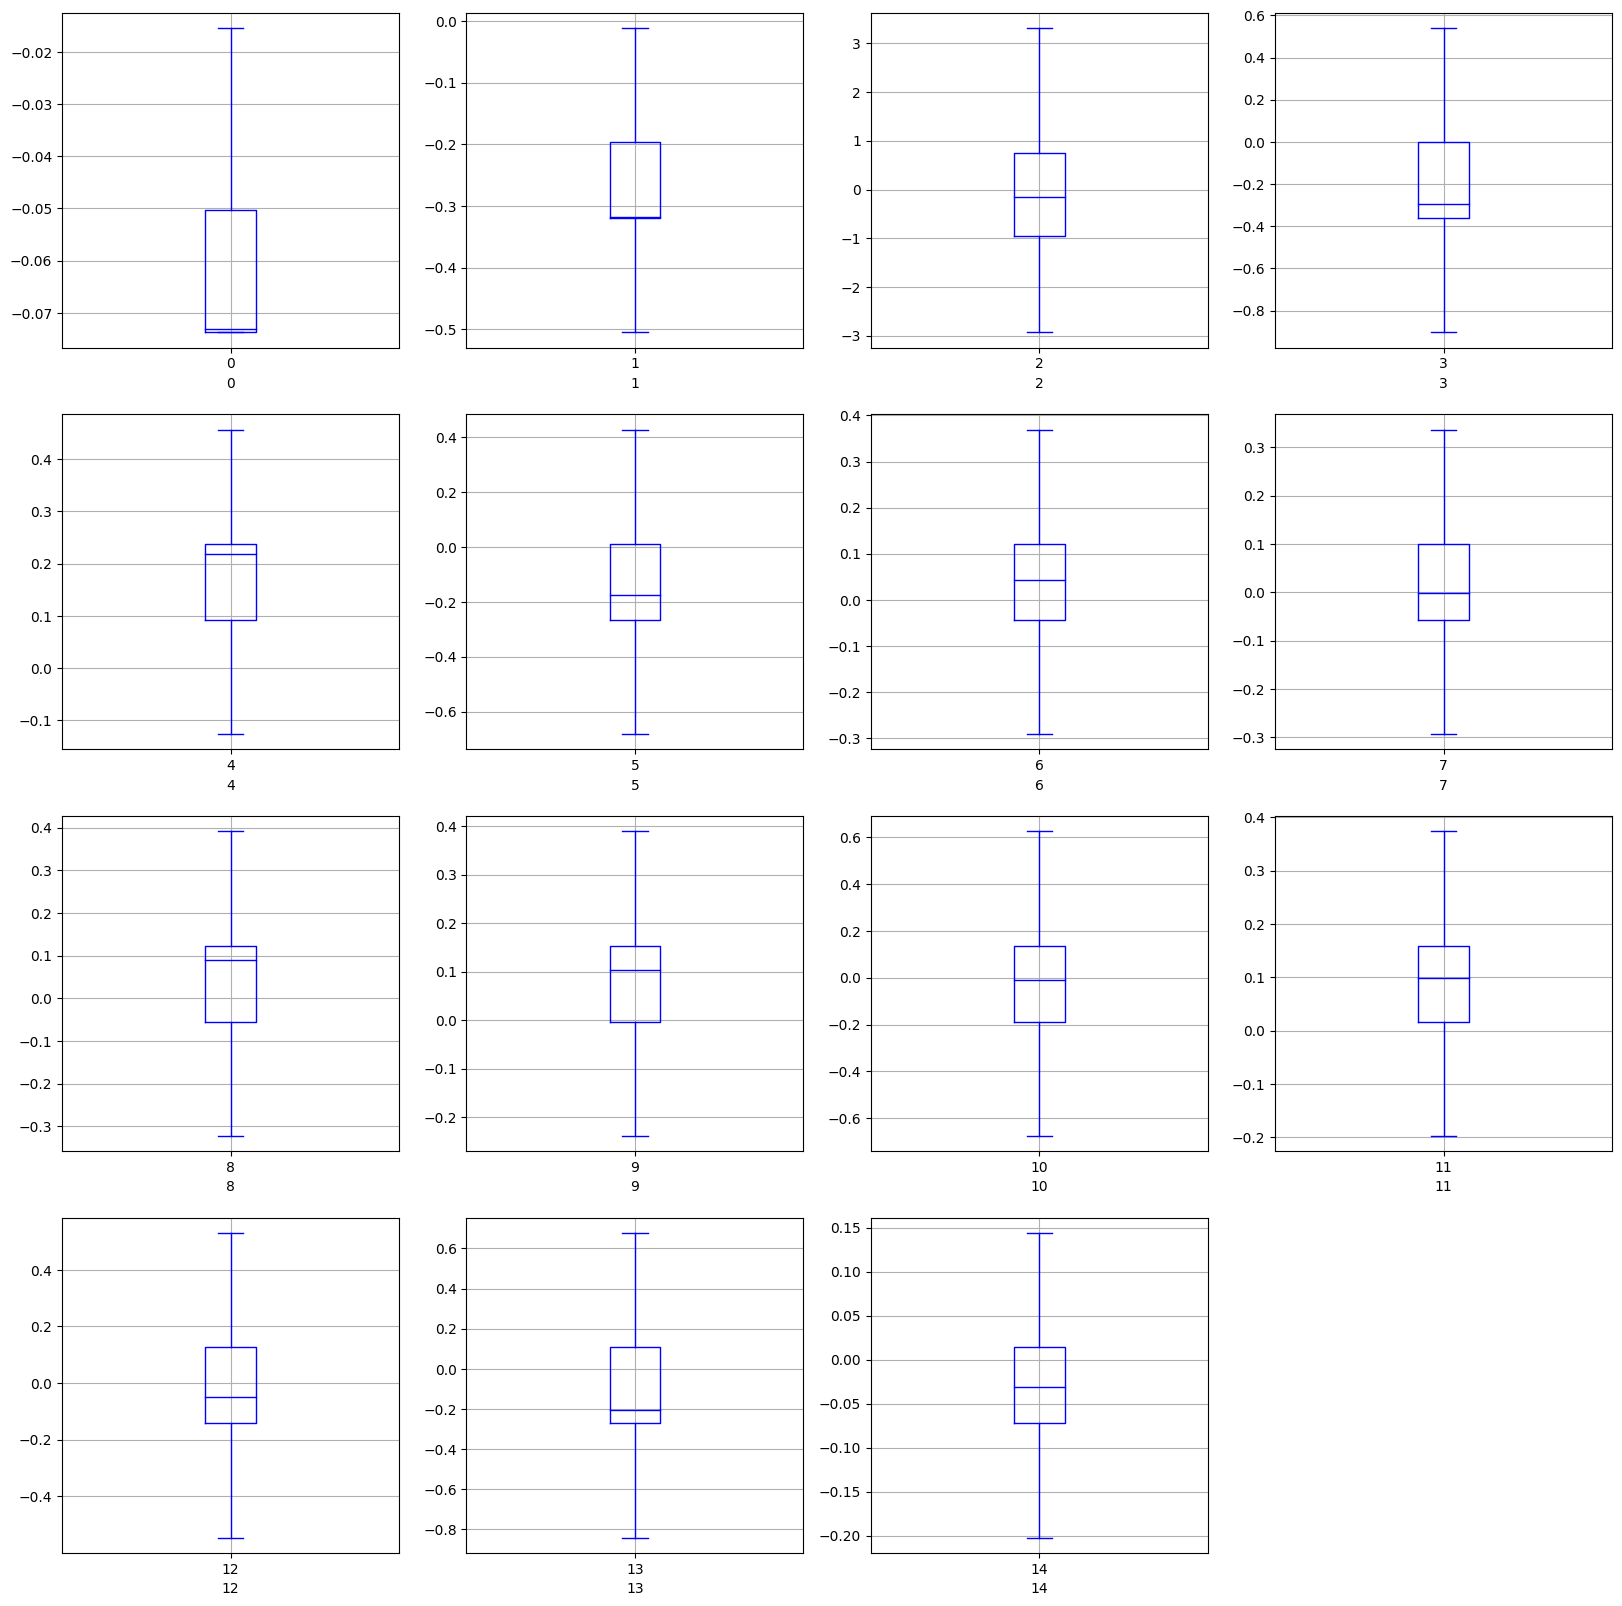

In [92]:
fig, axes = plt.subplots(4, 4, figsize=(20,20))

axes = axes.flatten()

for i, col in enumerate(X_train_reduced_scaled_outliers_clipped.columns):
    X_train_reduced_scaled_outliers_clipped.boxplot(column=col, ax=axes[i], color="blue")
    axes[i].set_xlabel(col)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.show()

# 6. Implementing more complex models

## 6.1. Random Forest

Best Parameters:
{'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 100}

cross validation score:
[0.88248955 0.87505806 0.87784487 0.88248955 0.87407063]

#####################         Train results         #####################
f1 score: 0.8819221150410861

conf_matrix:
[[4505  877]
 [ 445 4937]]

precision score: 0.8491572067423461

recall score: 0.9173169825343739

auc_roc: 0.9435181836422687


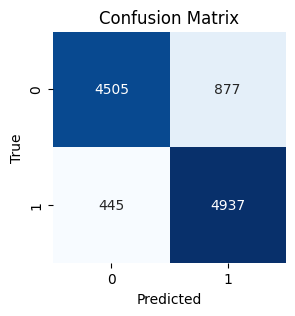

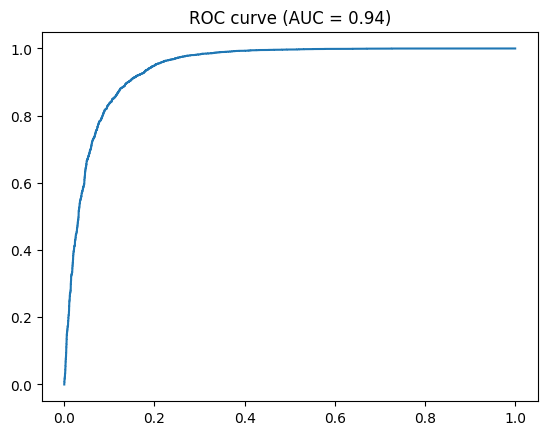


#####################         Test results         #####################
f1 score: 0.8952459353776498

conf_matrix:
[[1930  377]
 [ 132 2175]]

precision score: 0.8522727272727273

recall score: 0.9427828348504551

auc_roc: 0.9560960977210949


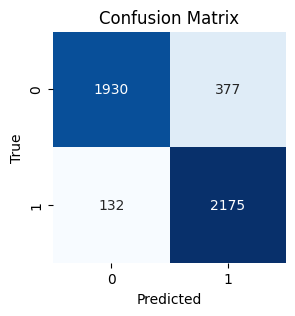

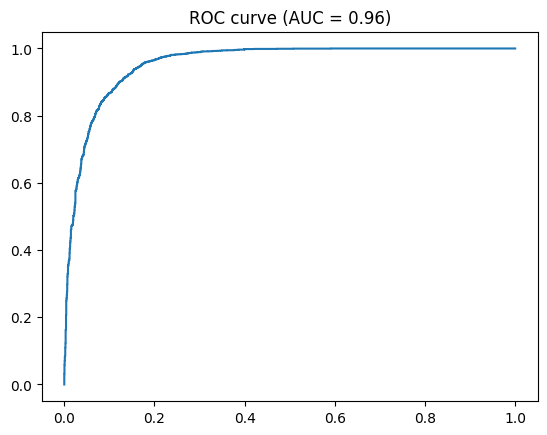

In [93]:
RF_6_1 = RandomForestClassifier()

param_grid = {
    "n_estimators": [100],
    "max_depth": randint(low=2, high=10),
    "min_samples_split": randint(low=2, high=10),
    "min_samples_leaf": randint(low=2, high=5),
    "max_features": ["log2", "sqrt"],
}

random_search = RandomizedSearchCV(
    estimator = RF_6_1, 
    param_distributions = param_grid, 
    n_iter = 20,
    scoring = make_scorer(f1_score),
    cv = 5,
    random_state = 42
)

random_search.fit(X_train_reduced_scaled_outliers_clipped, y_train_reduced)

best_model_RF_6_1 = random_search.best_estimator_
best_params_RF_6_1 = random_search.best_params_

cross_val_score_RF_6_1 = cross_val_score(best_model_RF_6_1, X_train_reduced_scaled_outliers_clipped, y_train_reduced, cv=5)

print("Best Parameters:")
print(best_params_RF_6_1)
print()
print("cross validation score:")
print(cross_val_score_RF_6_1)
print()

y_train_pred_RF_6_1 = cross_val_predict(best_model_RF_6_1, X_train_reduced_scaled_outliers_clipped, y_train_reduced, cv=5)
y_train_pred_proba_RF_6_1 = cross_val_predict(best_model_RF_6_1, X_train_reduced_scaled_outliers_clipped, y_train_reduced, 
                                            cv=5, method="predict_proba")[:, 1]

importance_RF_6_1 = best_model_RF_6_1.feature_importances_


print("#####################         Train results         #####################")
f1 = f1_score(y_train_reduced, y_train_pred_RF_6_1)
conf_matrix = confusion_matrix(y_train_reduced, y_train_pred_RF_6_1)
precision = precision_score(y_train_reduced, y_train_pred_RF_6_1)
recall = recall_score(y_train_reduced, y_train_pred_RF_6_1)
auc_roc = roc_auc_score(y_train_reduced, y_train_pred_proba_RF_6_1)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_train_reduced, y_train_pred_proba_RF_6_1)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()


y_test_pred_RF_6_1 = best_model_RF_6_1.predict(X_test_reduced_scaled_outliers_clipped)
y_test_pred_proba_RF_6_1 = best_model_RF_6_1.predict_proba(X_test_reduced_scaled_outliers_clipped)[:,1]


print()
print("#####################         Test results         #####################")
f1 = f1_score(y_test_reduced, y_test_pred_RF_6_1)
auc_roc = roc_auc_score(y_test_reduced, y_test_pred_proba_RF_6_1)
conf_matrix = confusion_matrix(y_test_reduced, y_test_pred_RF_6_1)
precision = precision_score(y_test_reduced, y_test_pred_RF_6_1)
recall = recall_score(y_test_reduced, y_test_pred_RF_6_1)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test_reduced, y_test_pred_proba_RF_6_1)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()

## 6.2. XGBoost

Due to hardware and memory limitation, we weren't able to test a wide range of hyperparameters

Best Parameters:
{'subsample': 0.75, 'n_estimators': 300, 'max_depth': 30, 'learning_rate': 0.05}

cross validation score:
[0.9386902  0.92475615 0.92661403 0.92754296 0.92890335]

#####################         Train results         #####################
f1 score: 0.9315093150931509

conf_matrix:
[[4828  554]
 [ 207 5175]]

precision score: 0.9032990050619655

recall score: 0.9615384615384616

auc_roc: 0.9745876741235667


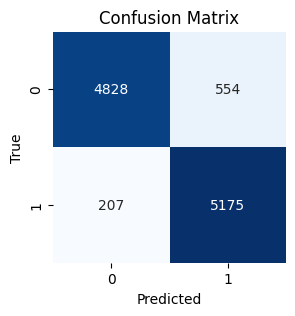

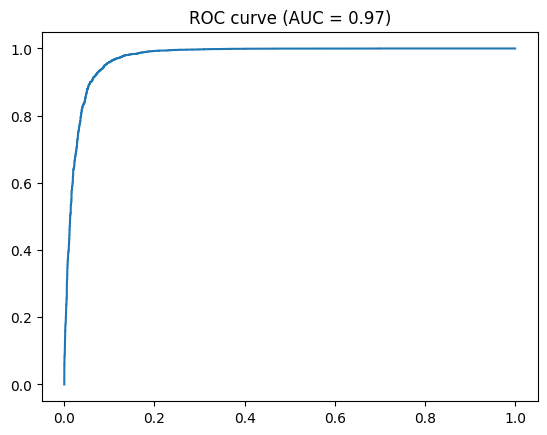


#####################         Test results         #####################
f1 score: 0.9467928496319663

conf_matrix:
[[2110  197]
 [  56 2251]]

precision score: 0.9195261437908496

recall score: 0.9757260511486779

auc_roc: 0.9833560962668226


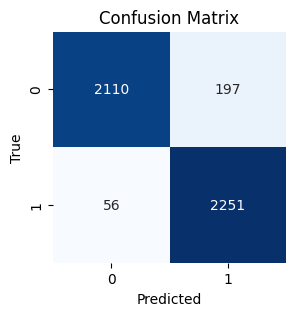

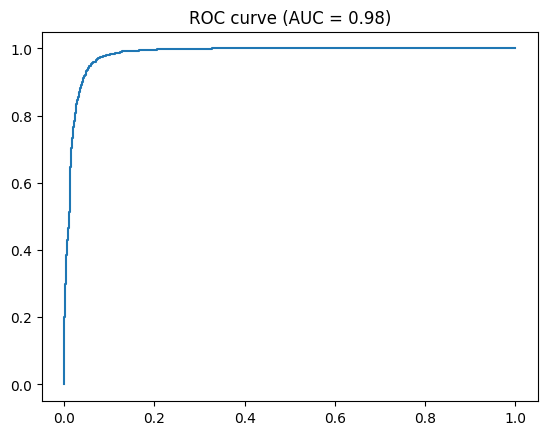

In [94]:
xgb_6_2 = xgb.XGBClassifier()

param_grid = {
    "n_estimators": [200, 300],
    "max_depth": [20, 30],
    "learning_rate": [0.01, 0.05], 
    "subsample": [0.75, 1],
    #"colsample_bytree": [0.8, 1],
}

random_search = RandomizedSearchCV(
    estimator = xgb_6_2, 
    param_distributions=param_grid, 
    n_iter = 10,
    scoring = make_scorer(f1_score), #"f1_macro",
    cv = 5,
    random_state = 42
)

random_search.fit(X_train_reduced_scaled_outliers_clipped, y_train_reduced)

best_model_xgb_6_2 = random_search.best_estimator_
best_params_xgb_6_2 = random_search.best_params_

cross_val_score_xgb_6_2 = cross_val_score(best_model_xgb_6_2, X_train_reduced_scaled_outliers_clipped, y_train_reduced, cv=5)

print("Best Parameters:")
print(best_params_xgb_6_2)
print()
print("cross validation score:")
print(cross_val_score_xgb_6_2)
print()

y_train_pred_xgb_6_2 = cross_val_predict(best_model_xgb_6_2, X_train_reduced_scaled_outliers_clipped, y_train_reduced, cv=5)
y_train_pred_proba_xgb_6_2 = cross_val_predict(best_model_xgb_6_2, X_train_reduced_scaled_outliers_clipped, y_train_reduced, 
                                            cv=5, method="predict_proba")[:, 1]

importance_xgb_6_2 = best_model_xgb_6_2.feature_importances_


print("#####################         Train results         #####################")
f1 = f1_score(y_train_reduced, y_train_pred_xgb_6_2)
conf_matrix = confusion_matrix(y_train_reduced, y_train_pred_xgb_6_2)
precision = precision_score(y_train_reduced, y_train_pred_xgb_6_2)
recall = recall_score(y_train_reduced, y_train_pred_xgb_6_2)
auc_roc = roc_auc_score(y_train_reduced, y_train_pred_proba_xgb_6_2)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_train_reduced, y_train_pred_proba_xgb_6_2)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()


y_test_pred_xgb_6_2 = best_model_xgb_6_2.predict(X_test_reduced_scaled_outliers_clipped)
y_test_pred_proba_xgb_6_2 = best_model_xgb_6_2.predict_proba(X_test_reduced_scaled_outliers_clipped)[:,1]


print()
print("#####################         Test results         #####################")
f1 = f1_score(y_test_reduced, y_test_pred_xgb_6_2)
auc_roc = roc_auc_score(y_test_reduced, y_test_pred_proba_xgb_6_2)
conf_matrix = confusion_matrix(y_test_reduced, y_test_pred_xgb_6_2)
precision = precision_score(y_test_reduced, y_test_pred_xgb_6_2)
recall = recall_score(y_test_reduced, y_test_pred_xgb_6_2)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test_reduced, y_test_pred_proba_xgb_6_2)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()

## 6.3. creating an ensemble of models

In [95]:
y_pred_rf = best_model_RF_6_1.predict_proba(X_test_reduced_scaled_outliers_clipped)[:,1]
y_pred_xgb = best_model_xgb_6_2.predict_proba(X_test_reduced_scaled_outliers_clipped)[:, 1]

y_pred_ensemble = (y_pred_rf + y_pred_xgb) / 2
y_pred_ensemble_labels = (y_pred_ensemble > 0.5).astype(int)

precision = precision_score(y_test_reduced, y_pred_ensemble_labels)
recall = recall_score(y_test_reduced, y_pred_ensemble_labels)
f1 = f1_score(y_test_reduced, y_pred_ensemble_labels)
roc_auc = roc_auc_score(y_test_reduced, y_pred_ensemble)

print("F1-Score:", f1)
print("precision:", precision)
print("recall:", recall)
print("ROC_AUC:", roc_auc)

F1-Score: 0.9427257525083612
precision: 0.9103754541784417
recall: 0.9774599046380581
ROC_AUC: 0.9767960875186411


As we see, the best model is XGB and even the ensemble model didn't outperform XGB. So, We'll use the XGBoost for predicting the unseen data

# Important features of PCA

In this part, we listed the top 3 features in each component. Interestingly, in 5 out of 15 components, the new "ratio" variables that we created (refer to the part 2), are among top 3 features.


In [96]:
data = []

# Iterate over each component
for i in range(pca.n_components_):
    # Get the absolute coefficients for the current component
    abs_coefficients = np.abs(pca.components_[i])
    sorted_indices = np.argsort(abs_coefficients)[::-1]
    sorted_features = [X_train.columns[j] for j in sorted_indices]
    sorted_coefficients = abs_coefficients[sorted_indices]

    top_indices = sorted_indices[:3]
    top_features = [X_train.columns[j] for j in top_indices]
    top_coefficients = sorted_coefficients[:3]

    # Create a dictionary for the current component
    component_data = {
        'Component': f'Component_{i+1}',
        'Feature': top_features,
        'Feature Importance': top_coefficients
    }

    # Append the dictionary to the list
    data.append(component_data)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

df

,Component,Feature,Feature Importance
0,Component_1,"[high_amt_sum30_count30_ratio, swipe_sum30_count30_ratio, SUM_INTERNET_PAST_30DAY]","[0.9994424623529303, 0.031149093684304994, 0.010333027636620175]"
1,Component_2,"[swipe_sum30_count30_ratio, high_amt_sum30_count30_ratio, SUM_RECREA_PAST_30DAY]","[0.9993717754439745, 0.031199181789371228, 0.008754337002376803]"
2,Component_3,"[AVAIL_CRDT, SUM_RECREA_PAST_30DAY, SUM_HIGH_RECREA_PAST_30DAY]","[0.9993923620249258, 0.0161338682886678, 0.015632194560426988]"
3,Component_4,"[recrea_mean30_count_30_ratio, SUM_RECREA_PAST_30DAY, SUM_INTERNET_PAST_30DAY]","[0.4884785790456473, 0.47991270819433574, 0.42710204728618717]"
4,Component_5,"[SUM_MANUAL_ENTRY_PAST_30DAY, SUM_INTERNET_PAST_30DAY, SUM_GIFT_CARD_PAST_30DAY]","[0.7232545790762308, 0.39498283420068625, 0.3311059281821187]"
5,Component_6,"[SUM_INTERNET_PAST_30DAY, SUM_GIFT_CARD_PAST_30DAY, SUM_HIGH_RECREA_PAST_30DAY]","[0.5532173184327736, 0.4220068842099607, 0.4020406787490757]"
6,Component_7,"[SUM_MANUAL_ENTRY_PAST_30DAY, SUM_GIFT_CARD_PAST_30DAY, SUM_RECREA_PAST_30DAY]","[0.5793338622884178, 0.45735828933435724, 0.3210415929606677]"
7,Component_8,"[SUM_HIGH_RECREA_PAST_30DAY, SUM_RECREA_PAST_7DAY, SUM_DEAL_PAST_30DAY]","[0.436337745100694, 0.43391236206877526, 0.3507624725832492]"
8,Component_9,"[SUM_RECREA_PAST_7DAY, MAX_RECREA_PAST_7DAY, MEAN_HIGH_AMT_PAST_7DAY]","[0.5288223305842312, 0.36343558127391484, 0.276447745912285]"
9,Component_10,"[SUM_HIGH_RECREA_PAST_30DAY, SUM_INTERNET_PAST_30DAY, SUM_GIFT_CARD_PAST_30DAY]","[0.45185435305781757, 0.39954143835267286, 0.3941152846500546]"


In [97]:
xgb_feature_importance_df = pd.DataFrame({"Component #": X_train_reduced_scaled_outliers_clipped.columns, 
                                      "Importance %": importance_xgb_6_2 *100}).sort_values(by="Importance %", ascending=False)

xgb_feature_importance_df.set_index('Component #', inplace=True)
xgb_feature_importance_df

,Importance %
Component #,
1,25.118324
8,7.452089
7,7.126501
5,7.100728
6,6.574455
13,5.681318
4,5.292789
0,4.994753
2,4.774518


# Conclusion

In this part of our fraud detection series, we constructed an variety of models to safeguard the financial sector against fraudulent activities. Through rigorous experimentation, we crafted models employing decision trees, random forests, and XGBoost. Among these, XGBoost emerged as the standout performer.

One of the key challenges we encountered was overfitting, a hurdle we overcame by employing Principal Component Analysis (PCA). Through meticulous tuning, we determined that utilizing 15 principal components struck the optimal balance, ensuring our models' ability to generalize without sacrificing accuracy. Notably, within these 15 components, 5 were comprised of the ratio variables we created in [**Part 2**](https://github.com/ameiln/EDA-n-Modeling/blob/main/a-deep-dive-into-fraud-detection-through-eda.ipynb). This convergence underscores the significance of our earlier exploratory efforts, where the foundations for our successful models were laid.

In the face of ever-evolving fraud tactics, this research stands as a testament to the power of data-driven strategies and collaborative models. The amalgamation of advanced machine learning techniques, thoughtful feature engineering, and the judicious application of dimensionality reduction not only fortified our defense against fraud but also illuminated new pathways for future advancements in the field. As the financial landscape continues to evolve, our commitment to pushing the boundaries of fraud detection remains unwavering, ensuring a secure and trustworthy environment for all stakeholders involved.